In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from shap import plots, Explanation
from shap.explainers import TreeExplainer
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import fasttreeshap

pd.set_option('display.max_columns', None)

In [50]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest, average='binary'):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain, average = average),
                metricsObj.recall_score(yTrain, yPredTrain, average = average),
                metricsObj.f1_score(yTrain, yPredTrain, average = average),
                metricsObj.roc_auc_score(yTrain, yPredTrain, average = None if average == 'binary' else average)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest, average = average),
               metricsObj.recall_score(yTest, yPredTest, average = average),
               metricsObj.f1_score(yTest, yPredTest, average = average),
               metricsObj.roc_auc_score(yTest, yPredTest, average = None if average == 'binary' else average)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

Here I change the type of some feature becuase since they come from a network package they are supposed to be a certain amount of bit maximum, I also checked before to do the change.

Then I will eclude the ip of the hosts, the port and the Unnamed: 0. Because the ip and ports are categorical but they are to many to fit in the model, and also there is not a good reason for train the model over the ip since it change based on the network so the attacker will always have a different one. About the Unnamed: 0 you can use that number to split this csv in mani csvs which is not a thing that we need to do so I removed that feature as well.

In [51]:
dtype_dict = {
    'Unnamed: 0': 'uint32',
    'uid': 'str',
    'originh': 'object',
    'originp': 'uint16',
    'responh': 'object',
    'responp': 'uint16',
    'flow_duration': 'float64',
    'fwd_pkts_tot': 'uint64',
    'bwd_pkts_tot': 'uint64',
    'fwd_data_pkts_tot': 'uint64',
    'bwd_data_pkts_tot': 'uint64',
    'fwd_pkts_per_sec': 'float64',
    'bwd_pkts_per_sec': 'float64',
    'flow_pkts_per_sec': 'float64',
    'down_up_ratio': 'float32',
    'fwd_header_size_tot': 'uint64',
    'fwd_header_size_min': 'uint8',
    'fwd_header_size_max': 'uint8',
    'bwd_header_size_tot': 'uint64',
    'bwd_header_size_min': 'uint8',
    'bwd_header_size_max': 'uint8',
    'flow_FIN_flag_count': 'uint64',
    'flow_SYN_flag_count': 'uint64',
    'flow_RST_flag_count': 'uint64',
    'fwd_PSH_flag_count': 'uint64',
    'bwd_PSH_flag_count': 'uint64',
    'flow_ACK_flag_count': 'uint64',
    'fwd_URG_flag_count': 'uint64',
    'bwd_URG_flag_count': 'uint64',
    'flow_CWR_flag_count': 'uint64',
    'flow_ECE_flag_count': 'uint64',
    'fwd_pkts_payload.min': 'uint16',
    'fwd_pkts_payload.max': 'uint16',
    'fwd_pkts_payload.tot': 'float64',
    'fwd_pkts_payload.avg': 'float64',
    'fwd_pkts_payload.std': 'float64',
    'bwd_pkts_payload.min': 'uint16',
    'bwd_pkts_payload.max': 'uint16',
    'bwd_pkts_payload.tot': 'float64',
    'bwd_pkts_payload.avg': 'float64',
    'bwd_pkts_payload.std': 'float64',
    'flow_pkts_payload.min': 'uint16',
    'flow_pkts_payload.max': 'uint16',
    'flow_pkts_payload.tot': 'float64',
    'flow_pkts_payload.avg': 'float64',
    'flow_pkts_payload.std': 'float64',
    'fwd_iat.min': 'float64',
    'fwd_iat.max': 'float64',
    'fwd_iat.tot': 'float64',
    'fwd_iat.avg': 'float64',
    'fwd_iat.std': 'float64',
    'bwd_iat.min': 'float64',
    'bwd_iat.max': 'float64',
    'bwd_iat.tot': 'float64',
    'bwd_iat.avg': 'float64',
    'bwd_iat.std': 'float64',
    'flow_iat.min': 'float64',
    'flow_iat.max': 'float64',
    'flow_iat.tot': 'float64',
    'flow_iat.avg': 'float64',
    'flow_iat.std': 'float64',
    'payload_bytes_per_second': 'float64',
    'fwd_subflow_pkts': 'float64',
    'bwd_subflow_pkts': 'float64',
    'fwd_subflow_bytes': 'float64',
    'bwd_subflow_bytes': 'float64',
    'fwd_bulk_bytes': 'float64',
    'bwd_bulk_bytes': 'float64',
    'fwd_bulk_packets': 'float32',
    'bwd_bulk_packets': 'float32',
    'fwd_bulk_rate': 'float64',
    'bwd_bulk_rate': 'float64',
    'active.min': 'float64',
    'active.max': 'float64',
    'active.tot': 'float64',
    'active.avg': 'float64',
    'active.std': 'float64',
    'idle.min': 'float64',
    'idle.max': 'float64',
    'idle.tot': 'float64',
    'idle.avg': 'float64',
    'idle.std': 'float64',
    'fwd_init_window_size': 'uint16',
    'bwd_init_window_size': 'uint16',
    'fwd_last_window_size': 'uint16',
    'traffic_category': 'object',
    'Label': 'bool'
}

selected_features = [
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size", "traffic_category", "Label"
]

In [52]:
ds = pd.read_csv('HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [53]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555278 entries, 0 to 555277
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             555278 non-null  float64
 1   fwd_pkts_tot              555278 non-null  uint64 
 2   bwd_pkts_tot              555278 non-null  uint64 
 3   fwd_data_pkts_tot         555278 non-null  uint64 
 4   bwd_data_pkts_tot         555278 non-null  uint64 
 5   fwd_pkts_per_sec          555278 non-null  float64
 6   bwd_pkts_per_sec          555278 non-null  float64
 7   flow_pkts_per_sec         555278 non-null  float64
 8   down_up_ratio             555278 non-null  float32
 9   fwd_header_size_tot       555278 non-null  uint64 
 10  fwd_header_size_min       555278 non-null  uint8  
 11  fwd_header_size_max       555278 non-null  uint8  
 12  bwd_header_size_tot       555278 non-null  uint64 
 13  bwd_header_size_min       555278 non-null  u

In [54]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000,5.552780e+05,555278.000000,5.552780e+05,555278.000000,555278.000000,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,5.552780e+05,555278.000000,555278.000000,555278.000000
mean,9.306544,18.264091,18.892578,7.956928,15.803417,1720.704202,1674.140666,3394.844869,0.887003,6.361381e+02,19.901433,24.607501,5.754280e+02,16.545190,19.689366,0.562095,0.923988,0.503098,7.084219,10.782839,34.937831,0.001439,0.000011,0.002329,0.000038,22.699050,207.591415,1.872353e+03,52.682038,56.488003,31.246709,1252.857824,2.659391e+04,309.276711,363.239480,22.705447,1263.603752,2.846627e+04,186.045581,299.247061,8.932046e+05,5.102050e+06,9.134269e+06,1.190675e+06,9.329549e+05,1.528412e+04,4.232945e+06,7.234529e+06,3.454519e+05,9.634418e+05,8.937461e+05,5.202171e+06,9.312579e+06,1.080620e+06,7.082713e+05,3.516315e+04,12.653119,13.143448,1507.875699,1.592495e+04,18.984345,6.423852e+03,0.030403,2.513407,1.248447e+03,5.797473e+06,6.405506e+05,8.806241e+05,9.996375e+05,7.352865e+05,1.335883e+05,3.490637e+06,5.000630e+06,8.312942e+06,4.073219e+06,7.992576e+05,14750.725718,21005.879513,4546.872210
std,101.802730,463.901484,469.078877,73.441224,467.349374,4994.579973,4548.503983,9316.856663,0.511737,1.762560e+04,12.524893,16.577095,1.495092e+04,12.151789,15.924656,0.825811,1.018941,0.898075,73.276271,173.178129,932.467347,0.038844,0.003287,0.057376,0.006710,33.855436,287.060480,2.229359e+04,53.300571,89.671573,48.048751,2778.113834,4.004711e+05,569.643855,648.563051,33.867741,2774.930843,4.038744e+05,286.173780,524.095261,7.145073e+06,2.315940e+07,1.017571e+08,7.273388e+06,4.779988e+06,2.570718e+05,2.217501e+07,7.332596e+07,1.682992e+06,4.913081e+06,7.144566e+06,2.323061e+07,1.018055e+08,7.190908e+06,3.437376e+06,2.183837e+05,85.057715,89.297659,17077.706573,1.484343e+05,872.755605,

We can see from this graph that we don't have highly correlated features.

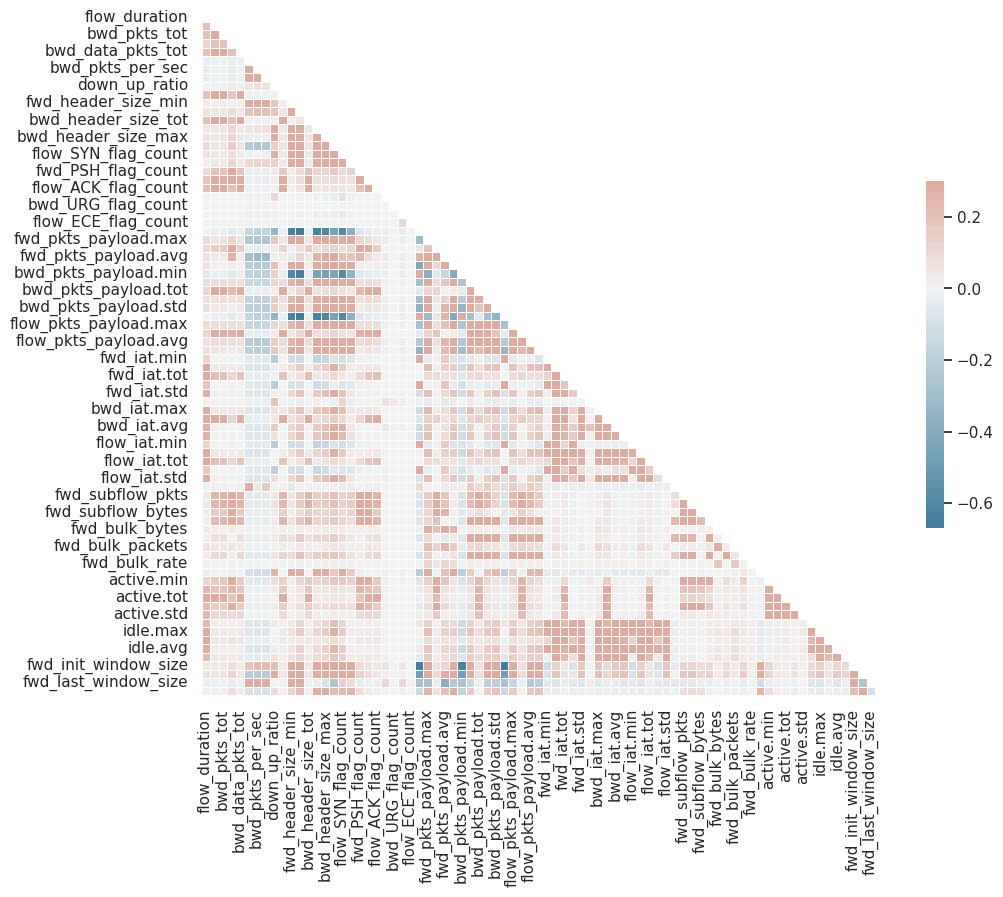

In [55]:
def show_corr_matrix():
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = ds.loc[:, ds.columns != 'traffic_category'].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
show_corr_matrix()

In [56]:
def compute_ratio(data):
    # Get ratio instead of raw numbers using normalize=True
    ratio = data['traffic_category'].value_counts(normalize=True)

    # Round and then convert to percentage
    ratio = ratio.round(4)*100

    # convert to a DataFrame and store in variable 'traffic_category_ratios'
    # We'll use this variable to compare ratios for samples 
    # selected using SRS and Stratified Sampling 
    traffic_category_ratios = pd.DataFrame({'Ratio':ratio})
    print(traffic_category_ratios)
    
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               62.57
Background           30.64
Probing               4.21
Bruteforce            1.06
Bruteforce-XML        0.93
XMRIGCC CryptoMiner   0.59


In [57]:
x_features = [    
    "flow_duration", "fwd_pkts_tot", "bwd_pkts_tot",
    "fwd_data_pkts_tot", "bwd_data_pkts_tot", "fwd_pkts_per_sec", "bwd_pkts_per_sec", "flow_pkts_per_sec",
    "down_up_ratio", "fwd_header_size_tot", "fwd_header_size_min", "fwd_header_size_max",
    "bwd_header_size_tot", "bwd_header_size_min", "bwd_header_size_max", "flow_FIN_flag_count",
    "flow_SYN_flag_count", "flow_RST_flag_count", "fwd_PSH_flag_count", "bwd_PSH_flag_count", "flow_ACK_flag_count",
    "fwd_URG_flag_count", "bwd_URG_flag_count", "flow_CWR_flag_count", "flow_ECE_flag_count",
    "fwd_pkts_payload.min", "fwd_pkts_payload.max", "fwd_pkts_payload.tot", "fwd_pkts_payload.avg",
    "fwd_pkts_payload.std", "bwd_pkts_payload.min", "bwd_pkts_payload.max", "bwd_pkts_payload.tot",
    "bwd_pkts_payload.avg", "bwd_pkts_payload.std", "flow_pkts_payload.min", "flow_pkts_payload.max",
    "flow_pkts_payload.tot", "flow_pkts_payload.avg", "flow_pkts_payload.std", "fwd_iat.min",
    "fwd_iat.max", "fwd_iat.tot", "fwd_iat.avg", "fwd_iat.std", "bwd_iat.min", "bwd_iat.max",
    "bwd_iat.tot", "bwd_iat.avg", "bwd_iat.std", "flow_iat.min", "flow_iat.max", "flow_iat.tot",
    "flow_iat.avg", "flow_iat.std", "payload_bytes_per_second", "fwd_subflow_pkts", "bwd_subflow_pkts",
    "fwd_subflow_bytes", "bwd_subflow_bytes", "fwd_bulk_bytes", "bwd_bulk_bytes", "fwd_bulk_packets",
    "bwd_bulk_packets", "fwd_bulk_rate", "bwd_bulk_rate", "active.min", "active.max", "active.tot",
    "active.avg", "active.std", "idle.min", "idle.max", "idle.tot", "idle.avg", "idle.std",
    "fwd_init_window_size", "bwd_init_window_size", "fwd_last_window_size"
]

In [133]:
ds.groupby('traffic_category').count().Label.to_dict()

{'Background': 170151,
 'Benign': 347431,
 'Bruteforce': 5884,
 'Bruteforce-XML': 5145,
 'Probing': 23388,
 'XMRIGCC CryptoMiner': 3279}

In [59]:
def test_zero_day(attack, features):
    sampling_weights = {'Background': 3279, 'Benign': 3279, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 3279, 'Bruteforce-XML': 3279}
    sampling_weights[attack] = 0
    
    rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
    X_res, y_res = rus.fit_resample(ds[features], ds.traffic_category)
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=42,  stratify=ds.loc[y_res.index].traffic_category)
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=2, max_depth=6, max_features=len(X_train.columns), random_state=42)
    cv_results = cross_validate(rf, X_res, ds.loc[y_res.index].Label, scoring='f1', cv=10, verbose=1)
    rf.fit(X_train,y_train)
    
    y_predicted = rf.predict(ds.where(ds.traffic_category == attack)[features].dropna())
    
    return metrics.f1_score(ds.where(ds.traffic_category == 'Bruteforce')['Label'].dropna().to_list(), y_predicted_crypto), cv_results['test_score'].mean()

In [60]:
# using the top 22 features from the decision tree selected with shap values

filtered_features =  [
"fwd_subflow_bytes",
"flow_duration",
"bwd_init_window_size"
]

Let's test if the decision tree is able to detect a CryptoMiner attack which has been remouved from the training dataset

In [119]:
sampling_weights = {'Background': 3279, 'Benign': 3279, 'XMRIGCC CryptoMiner': 3279, 'Probing': 3279, 'Bruteforce': 0, 'Bruteforce-XML': 3279}
# sampling_weights = {'Background': 5884, 'Benign': 5884, 'XMRIGCC CryptoMiner': 3279, 'Probing': 5884, 'Bruteforce': 5884, 'Bruteforce-XML': 5145}

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_weights)
# X_res, y_res = rus.fit_resample(ds[filtered_features], ds.traffic_category)
X_res, y_res = rus.fit_resample(ds[x_features], ds.traffic_category)

In [120]:
y_res

104945             Background
141415             Background
161295             Background
111764             Background
118268             Background
                 ...         
554809    XMRIGCC CryptoMiner
554464    XMRIGCC CryptoMiner
554400    XMRIGCC CryptoMiner
553312    XMRIGCC CryptoMiner
554938    XMRIGCC CryptoMiner
Name: traffic_category, Length: 16395, dtype: object

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=42,  stratify=ds.loc[y_res.index].traffic_category)

In [122]:
compute_ratio(ds.loc[y_test.index])

                     Ratio
traffic_category          
Probing              20.01
XMRIGCC CryptoMiner  20.01
Bruteforce-XML       20.01
Background           20.01
Benign               19.98


In [123]:
# bisognerebbe vedere quale f1 usare
rf = RandomForestClassifier(n_jobs=-1, n_estimators=2, max_depth=6, max_features=len(X_train.columns), random_state=42)
%time cv_results = cross_validate(rf, X_res, ds.loc[y_res.index].Label, scoring='f1', cv=10, verbose=1)
%time rf.fit(X_train,y_train)

CPU times: user 2.41 s, sys: 32.1 ms, total: 2.44 s
Wall time: 1.57 s
CPU times: user 192 ms, sys: 3.89 ms, total: 195 ms
Wall time: 111 ms


RandomForestClassifier(max_depth=6, max_features=79, n_estimators=2, n_jobs=-1,
                       random_state=42)

In [124]:
cv_results['test_score']

array([0.98795181, 0.99292214, 0.98495486, 0.98638427, 0.98791541,
       0.93549928, 0.93080569, 0.93485497, 0.93137719, 0.94066986])

In [125]:
cv_results['test_score'].mean()

0.9613335474431605

In [126]:
cv_results['test_score'].std()

0.026876230597594492

In [127]:
%time y_predicted_train = rf.predict(X_train)
%time y_predicted_test = rf.predict(X_test)

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 19.4 ms
CPU times: user 6.11 ms, sys: 0 ns, total: 6.11 ms
Wall time: 15.4 ms


In [128]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.954102,0.950290
1,PRECISION,0.929441,0.923510
2,RECALL,0.999365,1.000000
3,F1 SCORE,0.963135,0.960234
4,AUC,0.942793,0.937834


In [129]:
#%time y_predicted_crypto = rf.predict(ds.where(ds.traffic_category == 'Probing')[filtered_features].dropna())
%time y_predicted_crypto = rf.predict(ds.where(ds.traffic_category == 'Bruteforce')[x_features].dropna())

CPU times: user 312 ms, sys: 184 ms, total: 497 ms
Wall time: 505 ms


In [130]:
# here we can see that none of the observation was predicted as an attack

sum(y_predicted_crypto)

300

In [131]:
metrics.f1_score(ds.where(ds.traffic_category == 'Bruteforce')['Label'].dropna().to_list(), y_predicted_crypto)

0.09702457956015523